In [24]:
# libraries that will be used for the project
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import os
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.applications import efficientnet

## Preparing Dataset

In [2]:
def load_data(file):
    with open(file) as cap_file:
        caption = cap_file.readlines()
        cap_map = {}
        text_data = []
        skip_img = set()
        
    for i in caption:
        i = i.rstrip("\n")
        img, cap = i.split("\t")
        
        img = img.split("#")[0]
        img = os.path.join("Flicker8k_Dataset", img.strip())
        
        token = cap.strip().split()
        if len(token) < 5 or len(token) > 25:
            skip_img.add(img)
            continue
        if img.endswith("jpg") and img not in skip_img:
            cap =  "<start> " + cap.strip() + " <end>"
            text_data.append(cap)
            if img in cap_map:
                cap_map[img].append(cap)
            else:
                cap_map[img] = [cap]
            
    for img in skip_img:
        if img in cap_map:
            del cap_map[img]
    return cap_map, text_data

In [3]:
def split_train_val(cap,train_size=0.8, shuffle = True):
    all_img = list(cap.keys())
    if shuffle:
        np.random.shuffle(all_img)
        
    train_size = int(len(cap) * train_size)
    training_data = {img: cap[img] for img in all_img[:train_size]}
    validation_data = {img: cap[img] for img in all_img[train_size:]}
    
    return training_data, validation_data

In [4]:
cap_map, text_data = load_data("Flickr8k_text/Flickr8k.token.txt")

In [5]:
train_data, valid_data = split_train_val(cap_map)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


### Vectorizing the text Data

In [6]:
def standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [7]:
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=10000,
    output_mode="int",
    output_sequence_length=25,
    standardize=standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [8]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

In [9]:
def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

In [10]:
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

## Building Model

In [12]:
def get_cnn_model():
    model = efficientnet.EfficientNetB0(input_shape=(*(299, 299), 3), include_top=False, weights="imagenet")
    model.trainable = False
    model_out = model.output
    model_out = layers.Reshape((-1, model_out.shape[-1]))(model_out)
    cnn_model = keras.models.Model(model.input, model_out)
    return cnn_model
    

In [13]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")
        
    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

In [14]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [15]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=512, sequence_length=25, vocab_size=10000
        )
        self.out = layers.Dense(10000, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [16]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        #dd called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [17]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=512, dense_dim=512, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=512, ff_dim=512, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

### Model Training

In [18]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)



In [19]:
# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


In [20]:
# Create a learning rate schedule
num_train_steps = len(train_dataset) * 30
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=30,
    validation_data=valid_dataset,
    callbacks=[early_stopping]
)

Epoch 1/30
96/96 [==============================] - 1405s 15s/step - loss: 28.0413 - acc: 0.1350 - val_loss: 20.4184 - val_acc: 0.3173
Epoch 2/30
96/96 [==============================] - 1286s 13s/step - loss: 19.2183 - acc: 0.3239 - val_loss: 17.9372 - val_acc: 0.3582
Epoch 3/30
96/96 [==============================] - 1249s 13s/step - loss: 17.2230 - acc: 0.3594 - val_loss: 16.8163 - val_acc: 0.3742
Epoch 4/30
96/96 [==============================] - 1191s 12s/step - loss: 16.0322 - acc: 0.3821 - val_loss: 16.1371 - val_acc: 0.3879
Epoch 5/30
96/96 [==============================] - 1193s 12s/step - loss: 15.1269 - acc: 0.4026 - val_loss: 15.7346 - val_acc: 0.3958
Epoch 6/30
96/96 [==============================] - 1191s 12s/step - loss: 14.3821 - acc: 0.4202 - val_loss: 15.4981 - val_acc: 0.4009
Epoch 7/30
96/96 [==============================] - 1185s 12s/step - loss: 13.7282 - acc: 0.4362 - val_loss: 15.3692 - val_acc: 0.4028
Epoch 8/30
96/96 [==============================] - 119

In [21]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = 25 - 1
valid_images = list(valid_data.keys())

In [22]:
def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)



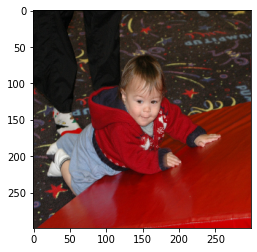

Predicted Caption:  a little girl in a red shirt is sitting on a red couch


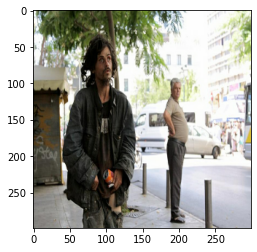

Predicted Caption:  two women in a coat and a black coat and a woman in a black coat


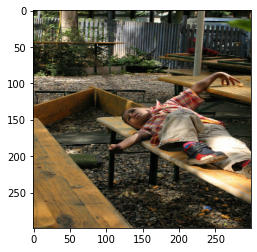

Predicted Caption:  a little boy is sitting on a wooden bench


In [25]:
generate_caption()
generate_caption()
generate_caption()